# Advanced Salary Prediction using Regression
This notebook predicts exact salary values using advanced regression techniques and feature engineering.

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

Salary Statistics (USD):
count     88584.000000
mean     157567.798417
std       73531.373158
min       15000.000000
25%      106097.250000
50%      146307.000000
75%      198600.000000
max      800000.000000
Name: salary_in_usd, dtype: float64


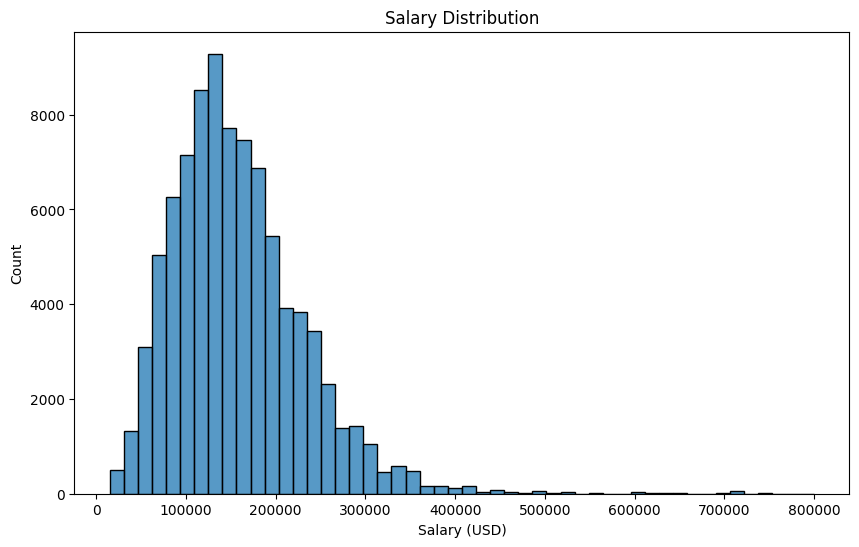

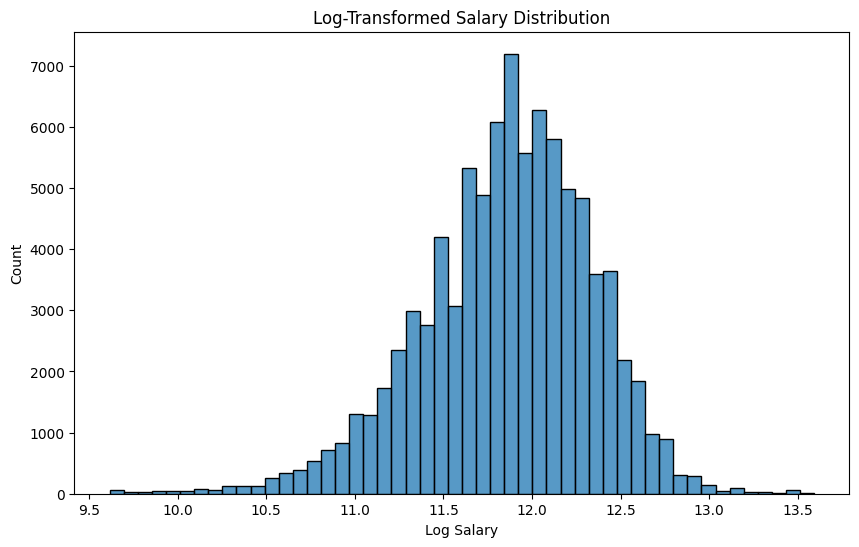

In [24]:
# Load and preprocess data
df = pd.read_csv('salaries.csv')

# Display initial statistics
print("Salary Statistics (USD):")
print(df['salary_in_usd'].describe())

# Plot salary distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['salary_in_usd'], bins=50)
plt.title('Salary Distribution')
plt.xlabel('Salary (USD)')
plt.ylabel('Count')
plt.show()

# Plot log-transformed salary distribution
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['salary_in_usd']), bins=50)
plt.title('Log-Transformed Salary Distribution')
plt.xlabel('Log Salary')
plt.ylabel('Count')
plt.show()

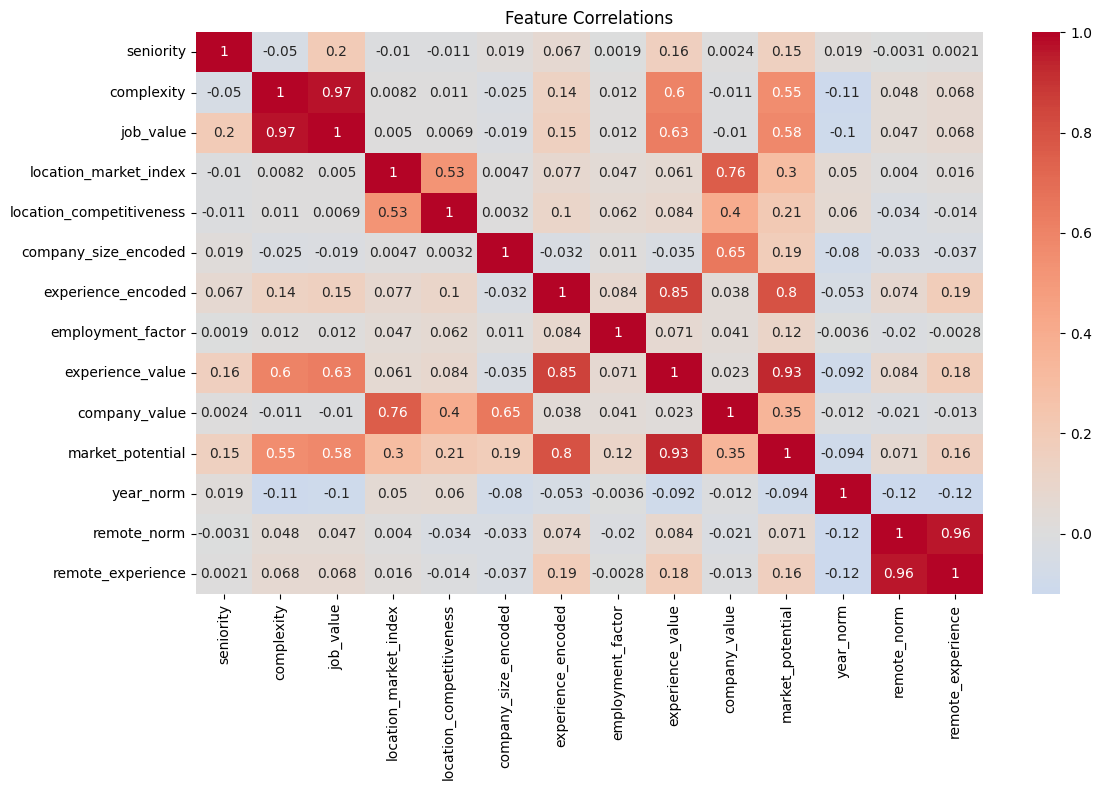

In [25]:
# Advanced Feature Engineering

# 1. Process job titles
def extract_job_features(title):
    title = title.lower()
    
    # Seniority scoring
    seniority_levels = {
        'principal': 5.0,
        'staff': 4.5,
        'senior': 4.0,
        'lead': 4.0,
        'mid': 3.0,
        'junior': 2.0,
        'entry': 1.0
    }
    seniority = 3.0  # default mid-level
    for level, score in seniority_levels.items():
        if level in title:
            seniority = score
            break
    
    # Role complexity scoring
    complexity_factors = {
        'architect': 1.5,
        'machine learning': 1.4,
        'data scientist': 1.4,
        'security': 1.3,
        'devops': 1.3,
        'full stack': 1.2,
        'backend': 1.2,
        'frontend': 1.1
    }
    complexity = 1.0
    for factor, score in complexity_factors.items():
        if factor in title:
            complexity = score
            break
            
    return pd.Series({
        'seniority': seniority,
        'complexity': complexity,
        'job_value': seniority * complexity
    })

# Extract job features
job_features = df['job_title'].apply(extract_job_features)
df = pd.concat([df, job_features], axis=1)

# 2. Location-based features
location_stats = df.groupby('company_location').agg({
    'salary_in_usd': ['mean', 'median', 'std', 'count']
}).fillna(0)

location_stats.columns = ['loc_mean_salary', 'loc_median_salary', 'loc_std_salary', 'loc_job_count']
location_stats = location_stats.reset_index()

# Add location features
df = df.merge(location_stats, on='company_location', how='left')
df['location_market_index'] = df['loc_mean_salary'] / df['loc_std_salary'].replace(0, df['loc_std_salary'].mean())
df['location_competitiveness'] = np.log1p(df['loc_job_count'])

# 3. Company size and experience encoding with market adjustment
size_map = {'S': 1, 'M': 2, 'L': 3}
exp_map = {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}
emp_map = {'FT': 1.0, 'CT': 0.8, 'FL': 0.7, 'PT': 0.5}

df['company_size_encoded'] = df['company_size'].map(size_map)
df['experience_encoded'] = df['experience_level'].map(exp_map)
df['employment_factor'] = df['employment_type'].map(emp_map)

# 4. Create advanced composite features
df['experience_value'] = df['experience_encoded'] * df['job_value']
df['company_value'] = df['company_size_encoded'] * df['location_market_index']
df['market_potential'] = df['experience_value'] * df['company_value'] * df['employment_factor']

# 5. Time and remote work features
df['year_norm'] = (df['work_year'] - df['work_year'].min()) / (df['work_year'].max() - df['work_year'].min())
df['remote_norm'] = df['remote_ratio'] / 100
df['remote_experience'] = df['remote_norm'] * df['experience_encoded']

# 6. Final feature selection
features = [
    'seniority',
    'complexity',
    'job_value',
    'location_market_index',
    'location_competitiveness',
    'company_size_encoded',
    'experience_encoded',
    'employment_factor',
    'experience_value',
    'company_value',
    'market_potential',
    'year_norm',
    'remote_norm',
    'remote_experience'
]

# Prepare features and target
X = df[features]
y = df['salary_in_usd']

# Log transform the target variable
y_log = np.log1p(y)

# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log, test_size=0.2, random_state=42)

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

XGBoost Model Performance:
Root Mean Squared Error: $68,791.74
Mean Absolute Error: $48,465.91
R² Score (on log scale): 0.2993
Mean Absolute Percentage Error: 33.62%


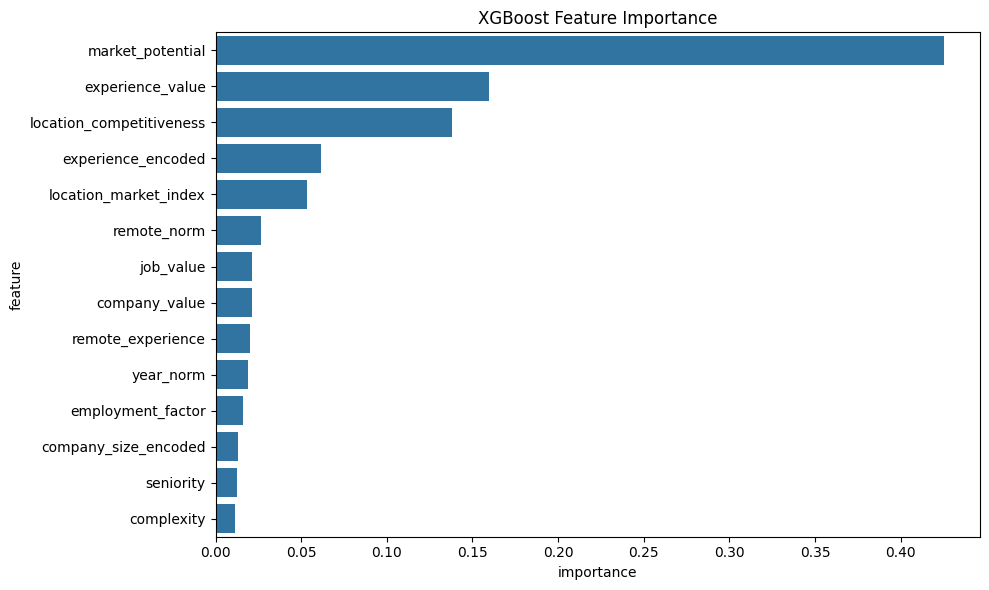

In [26]:
# Model 1: XGBoost Regressor
xgb_reg = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    min_child_weight=5,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

xgb_reg.fit(X_train, y_train)
xgb_pred_log = xgb_reg.predict(X_test)
xgb_pred = np.expm1(xgb_pred_log)

# Calculate metrics
def calculate_metrics(y_true, y_pred, y_true_log, y_pred_log):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true_log, y_pred_log)  # R² on log scale for better interpretation
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"Root Mean Squared Error: ${rmse:,.2f}")
    print(f"Mean Absolute Error: ${mae:,.2f}")
    print(f"R² Score (on log scale): {r2:.4f}")
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")

print("XGBoost Model Performance:")
calculate_metrics(np.expm1(y_test), xgb_pred, y_test, xgb_pred_log)

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': xgb_reg.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

Gradient Boosting Model Performance:
Root Mean Squared Error: $68,783.84
Mean Absolute Error: $48,464.68
R² Score (on log scale): 0.2998
Mean Absolute Percentage Error: 33.61%


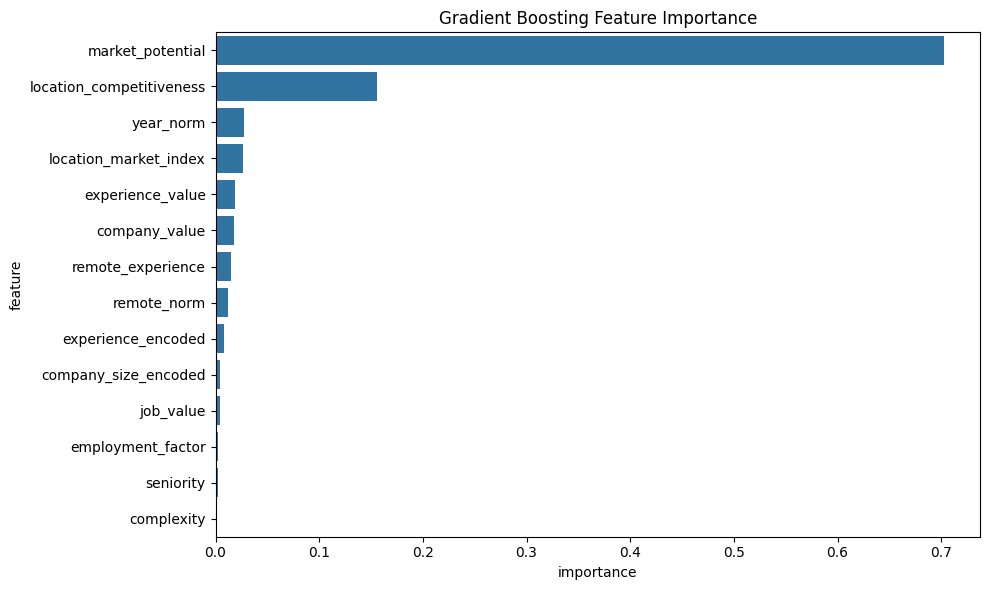

In [27]:
# Model 2: Gradient Boosting Regressor
gb_reg = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=3,
    subsample=0.8,
    random_state=42
)

gb_reg.fit(X_train, y_train)
gb_pred_log = gb_reg.predict(X_test)
gb_pred = np.expm1(gb_pred_log)

print("Gradient Boosting Model Performance:")
calculate_metrics(np.expm1(y_test), gb_pred, y_test, gb_pred_log)

# Plot feature importance
gb_feature_importance = pd.DataFrame({
    'feature': features,
    'importance': gb_reg.feature_importances_
})
gb_feature_importance = gb_feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=gb_feature_importance)
plt.title('Gradient Boosting Feature Importance')
plt.tight_layout()
plt.show()


XGBoost Prediction Analysis:
--------------------------------------------------
Error Distribution:
Within ±10%: 20.22%
Within ±20%: 39.49%
Within ±30%: 56.70%

Sample Predictions:

Actual: $250,000.00
Predicted: $166,534.61
Error: +33.4%

Actual: $178,538.00
Predicted: $166,627.08
Error: +6.7%

Actual: $85,000.00
Predicted: $170,642.66
Error: -100.8%

Actual: $294,000.00
Predicted: $184,752.47
Error: +37.2%

Actual: $169,700.00
Predicted: $179,368.84
Error: -5.7%

Gradient Boosting Prediction Analysis:
--------------------------------------------------
Error Distribution:
Within ±10%: 20.17%
Within ±20%: 39.35%
Within ±30%: 56.71%

Sample Predictions:

Actual: $130,000.00
Predicted: $93,887.75
Error: +27.8%

Actual: $500,000.00
Predicted: $151,491.65
Error: +69.7%

Actual: $42,000.00
Predicted: $93,887.75
Error: -123.5%

Actual: $110,000.00
Predicted: $166,646.74
Error: -51.5%

Actual: $282,900.00
Predicted: $163,335.71
Error: +42.3%


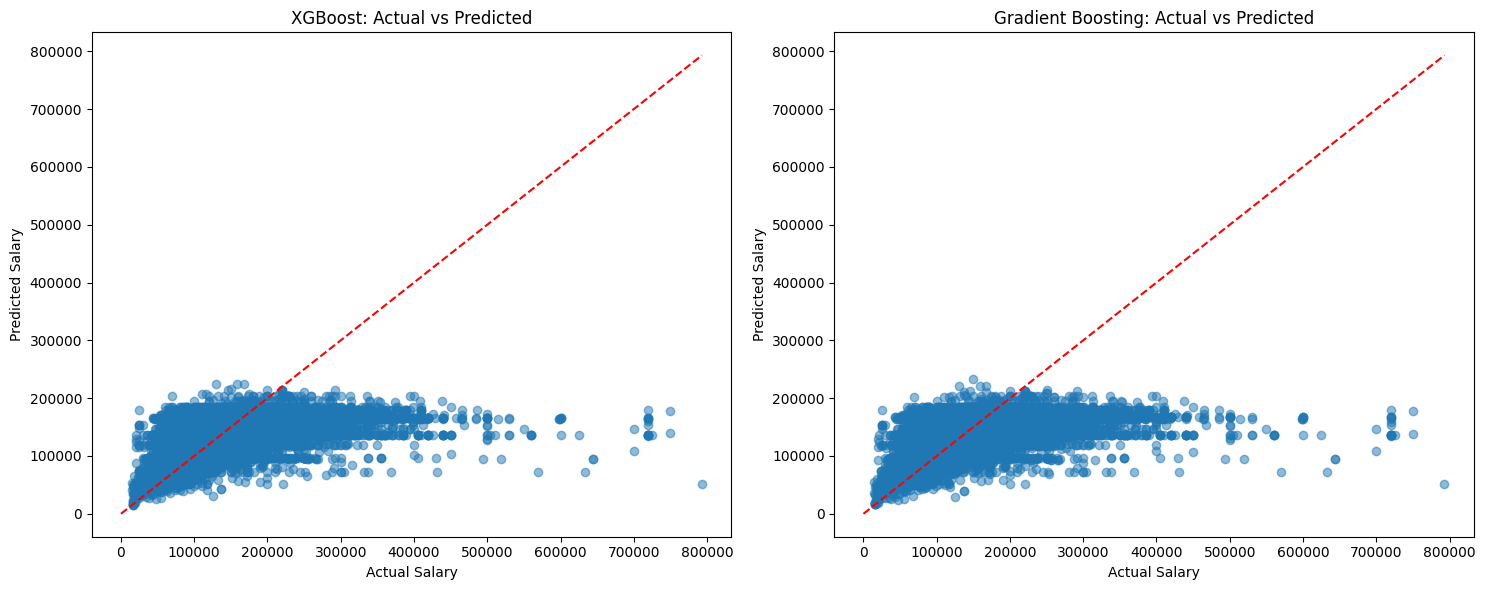

In [30]:
# Analyze predictions
def analyze_predictions(y_true, y_pred, model_name):
    # Ensure both are Series with the same index
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)
    
    errors = y_true - y_pred
    percentage_errors = (errors / y_true) * 100

    print(f"\n{model_name} Prediction Analysis:")
    print("-" * 50)

    # Error distribution
    print("Error Distribution:")
    print(f"Within ±10%: {np.mean(np.abs(percentage_errors) <= 10):.2%}")
    print(f"Within ±20%: {np.mean(np.abs(percentage_errors) <= 20):.2%}")
    print(f"Within ±30%: {np.mean(np.abs(percentage_errors) <= 30):.2%}")

    # Sample predictions
    print("\nSample Predictions:")
    sample_indices = np.random.choice(y_true.index, 5, replace=False)
    for idx in sample_indices:
        print(f"\nActual: ${y_true[idx]:,.2f}")
        print(f"Predicted: ${y_pred[idx]:,.2f}")
        print(f"Error: {percentage_errors[idx]:+.1f}%")


# Analyze both models
analyze_predictions(np.expm1(y_test), xgb_pred, "XGBoost")
analyze_predictions(np.expm1(y_test), gb_pred, "Gradient Boosting")

# Plot actual vs predicted
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(np.expm1(y_test), xgb_pred, alpha=0.5)
ax1.plot([0, np.expm1(y_test).max()], [0, np.expm1(y_test).max()], 'r--')
ax1.set_title('XGBoost: Actual vs Predicted')
ax1.set_xlabel('Actual Salary')
ax1.set_ylabel('Predicted Salary')

ax2.scatter(np.expm1(y_test), gb_pred, alpha=0.5)
ax2.plot([0, np.expm1(y_test).max()], [0, np.expm1(y_test).max()], 'r--')
ax2.set_title('Gradient Boosting: Actual vs Predicted')
ax2.set_xlabel('Actual Salary')
ax2.set_ylabel('Predicted Salary')

plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 70867, number of used features: 14
[LightGBM] [Info] Start training from score 11.857400
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

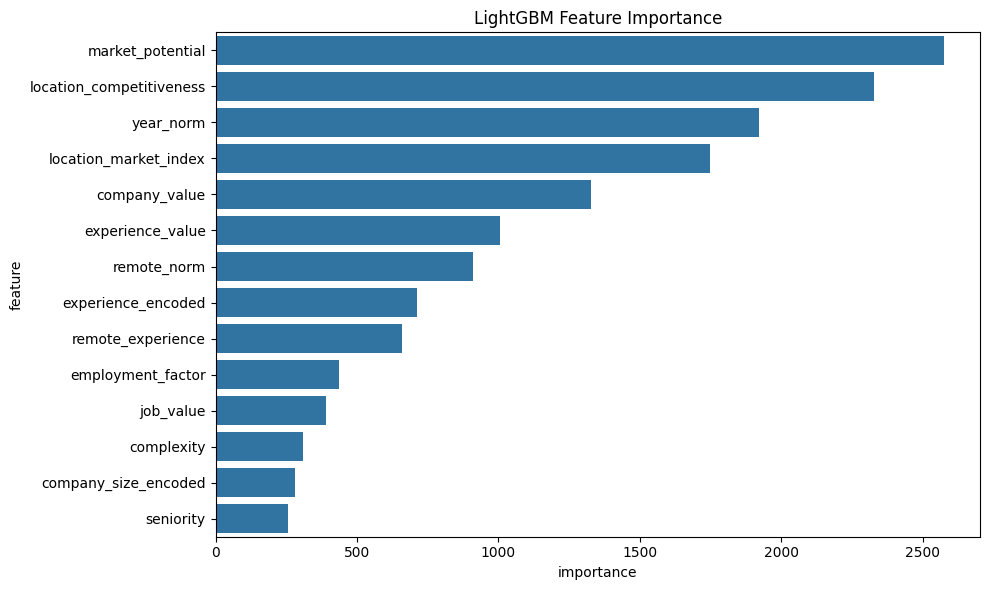

In [31]:
# Now to deal with lightgbm
import lightgbm as lgb

# LightGBM Model
lgb_reg = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    num_leaves=31,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

lgb_reg.fit(X_train, y_train)
lgb_pred_log = lgb_reg.predict(X_test)
lgb_pred = np.expm1(lgb_pred_log)

print("LightGBM Model Performance:")
calculate_metrics(np.expm1(y_test), lgb_pred, y_test, lgb_pred_log)

# Analyze predictions
analyze_predictions(np.expm1(y_test), pd.Series(lgb_pred, index=y_test.index), "LightGBM")

# Feature importance plot
lgb_feature_importance = pd.DataFrame({
    'feature': features,
    'importance': lgb_reg.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=lgb_feature_importance)
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()


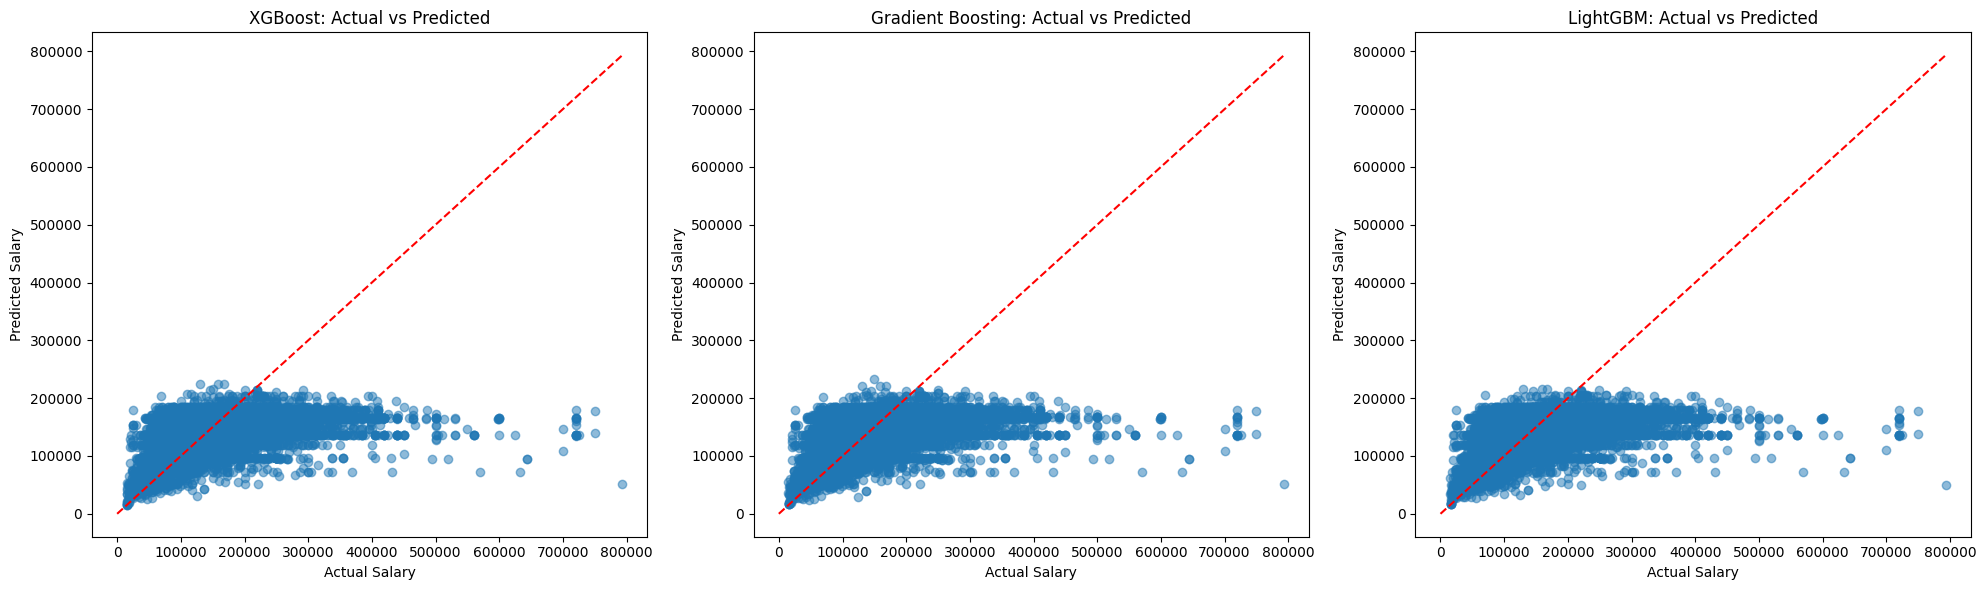

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# XGBoost
ax1.scatter(np.expm1(y_test), xgb_pred, alpha=0.5)
ax1.plot([0, np.expm1(y_test).max()], [0, np.expm1(y_test).max()], 'r--')
ax1.set_title('XGBoost: Actual vs Predicted')
ax1.set_xlabel('Actual Salary')
ax1.set_ylabel('Predicted Salary')

# Gradient Boosting
ax2.scatter(np.expm1(y_test), gb_pred, alpha=0.5)
ax2.plot([0, np.expm1(y_test).max()], [0, np.expm1(y_test).max()], 'r--')
ax2.set_title('Gradient Boosting: Actual vs Predicted')
ax2.set_xlabel('Actual Salary')
ax2.set_ylabel('Predicted Salary')

# LightGBM
ax3.scatter(np.expm1(y_test), lgb_pred, alpha=0.5)
ax3.plot([0, np.expm1(y_test).max()], [0, np.expm1(y_test).max()], 'r--')
ax3.set_title('LightGBM: Actual vs Predicted')
ax3.set_xlabel('Actual Salary')
ax3.set_ylabel('Predicted Salary')

plt.tight_layout()
plt.show()


In [ ]:
#Hyperparameter Tuning